In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import matplotlib.cm as cm

## Useful functions

In [2]:
# Some functions for convinience, allow fast plotting of stored data
def get_ligand_data(env_group, ligandname, time=None):
    if time:
        return env_group[ligandname][time]
    else:
        return env_group[ligandname].value

def plot_environment(env_group, ligandname, time, fig=plt.figure(), ax=None, vmin=None, vmax=None, cmap='Accent'):
    aspect = 1/env_group.attrs['Resolution']
    dimensions = env_group.attrs['Dimensions']
        
    if not ax:
        ax = fig.add_subplot(111)
    cax = ax.imshow(get_ligand_data(env_group, ligandname, time).T, interpolation='None', vmin=vmin, vmax=vmax,
                    extent=[0, dimensions[0], 0, dimensions[1]], origin='bottom', cmap=cmap)
    # ax.set_aspect(aspect)
    ax.set_title(ligandname)
    return fig, ax, cax

def get_positions(populations_group, population, time):
    if time:
        xpos = populations_group[population]['xpos'][time]
        ypos = populations_group[population]['ypos'][time]
    else:
        xpos = populations_group[population]['xpos']
        ypos = populations_group[population]['ypos']
    
    return xpos,ypos

def plot_populations(populations_group, time, fig=plt.figure(), ax=None):
    caxs = {}
    if not ax:
        ax = fig.add_subplot(111)
    
    colors = iter(cm.rainbow(np.linspace(0, 1, len(populations_group.keys()))))
    
    for population in populations_group:
        caxs[population] = ax.scatter(*get_positions(populations_group, population, time), label=population, color=next(colors), s=0.5)
    return fig, ax, caxs

In [3]:
# Functions that can be used to generate animations based on the simulated data
from matplotlib import animation, rc
from math import ceil, floor
from tqdm import tqdm
# output result directly into the JuPyter notebook
rc('animation', html='html5')

def get_colorbar_vmaxvmin(environment):
    print('Getting all values from env to calculate colorbar...')
    vmin = 0
    vmax = 0
    for lig in environment:
        ligdata = environment[lig].value
        vmin = min(vmin, np.amin(ligdata))
        vmax = max(vmax, np.amax(ligdata))
        del ligdata
    return vmin, vmax
        

def animate_from_start(environment, populations, start, skip=1, figsize=(10,10), savestep=1000, vscale=None):
    fig = plt.figure(figsize=figsize)
    if vscale is not None:
        vmin, vmax = vscale
    else:
        vmin, vmax = get_colorbar_vmaxvmin(environment)
    
    ligands = []
    axs = []
    for e in environment.keys():
        ligands.append(e)
    cols = min(3, len(ligands))
    rows = ceil(len(ligands)/cols)
    
    for i, pos in enumerate(range(1, len(ligands)+1)):
        ax = fig.add_subplot(rows, cols, pos)
        _, _, ligcax = plot_environment(environment, ligands[i], start, fig, ax, vmin, vmax)
        _, _, popcaxs = plot_populations(populations, start, fig, ax)
        axs.append((ligcax, popcaxs))
        ax.legend()
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(axs[0][0], cax=cbar_ax)
    frames = floor((environment[ligands[0]].shape[0]-start)/skip)
    # this just creates a progress bar of the animation progress
    pbar = tqdm(total=frames)
    def animate(i):
        for ligcount, ligand in enumerate(ligands):
            ligcax, popcaxs = axs[ligcount]
            ligcax.set_data(get_ligand_data(environment, ligand, start+i*skip))
            for name, popcax in popcaxs.items():
                # set offsets requires dims (#points x dimension)
                data = np.vstack(get_positions(populations, name, start+i*skip)).T
                # print(data.shape)
                popcax.set_offsets(data)
        pbar.update(1)
        if i == frames-1:
            pbar.close()
    
    return fig, animate, frames, dt*savestep*1000*skip

## Read data

In [4]:
# just in case this was run previously, clean up
if 'env' in locals():
    del env
if 'pops' in locals():
    del pops
if 'file' in locals() and file:
    file.close()
    del file

file = h5py.File('Example4.h5', libver='latest')
dt = file.attrs['dt']
savestep = file.attrs['saveStep']
env = file['Environment']
pops = file['Populations']
print('Dt: ',dt)
print('Savestep: ', savestep)

Dt:  0.00999999977648
Savestep:  200


### It is recommended to allways supply a value range (vscale), otherwise all data will be loaded into memory for max/min calculations

59it [00:21,  2.63it/s]                        


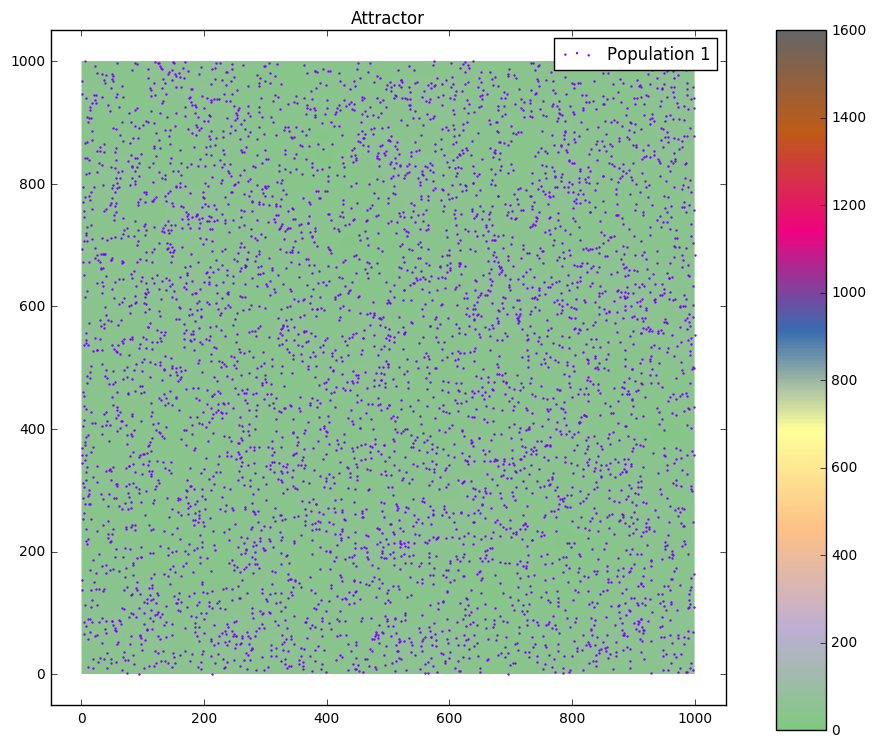

In [ ]:
# lower skip value for higher time resolution (skip=10 only plot every 10th frame)
fig, animate, frames, interval = animate_from_start(env, pops, 1, skip=10, savestep=savestep, vscale=(0, 1600))
# speed up video 30 fold
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=interval/30)
anim

In [ ]:
anim.save("Example4_fast.mp4", codec='h264')